In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import reduce
from matplotlib.lines import Line2D
import directlfq.lfq_manager as lfq_manager
from sklearn.decomposition import PCA 

In [29]:
fontsize = 16
lw = 2
size = 25
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='black', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)
palette = ['Greens', '#88B6E7', '#2878CC', '#174475', 'dimgrey']

names = ['indiv', 'mbr', 
         '+1_5', '+5_5', '+10_5', '+100_5',
         '+1_10', '+5_10', '+10_10', '+100_10',
         '+1_20', '+5_20', '+10_20', '+100_20']


In [30]:
path = '01_Data/00_Reports/DIANN180/'

reports = []
indiv_reports = []

for i in range(7):
    frame = pd.read_csv(path + 'r' + str(i+1) + '_report.tsv', sep='\t')
    indiv_reports.append(frame)
    
reports.append(pd.concat(indiv_reports))

for name in names:
    if name != 'indiv':
        frame = pd.read_csv(path + name + '_report.tsv', sep='\t')
        reports.append(frame)


In [31]:
path2 = '01_Data/01_Filtered_Reports/DIANN180/'

for i, frame in enumerate(reports):
    
    if i == 0:
        frame = frame[frame['Q.Value'] <= 0.01]     # run-specific qvalue for indiv reports
        frame = frame[frame['Global.PG.Q.Value'] <= 0.01]
    else:
        frame = frame[frame['Q.Value'] <= 0.01]
        frame = frame[frame['Lib.Q.Value'] <= 0.01]   # global qvalue for mbr-searched reports
        frame = frame[frame['Lib.PG.Q.Value'] <= 0.01]
        
    reports[i] = frame[frame['Run'].str.contains('00perc')] # removing MEs
    reports[i].to_csv(path2 + 'f_' + names[i] + '_report.tsv', sep='\t')
    lfq_manager.run_lfq(path2 + 'f_' + names[i] + '_report.tsv') # directLFQ incl. precursor re-normalization
    
# Manual file transfer to '01_Data/03_DirectLFQ_Protein_Quan/'

In [32]:
path2 = '01_Data/03_DirectLFQ_Protein_Quan/'

dataframes = []
for name in names:
        frame = pd.read_csv(path2 + 'f_' + name + '_report.tsv.protein_intensities.tsv', sep='\t')
        frame.replace(0, np.nan, inplace=True)
        dataframes.append(frame)

In [33]:
quans = []
for i, frame in enumerate(dataframes):
    quan_cols = [c for c in frame if '_KK_' in c]
    quan = frame[['Protein.Group'] + quan_cols].set_index('Protein.Group')
    quan.columns = [names[i]] * len(quan.columns)
    quans.append(quan)
    
merge = reduce(lambda  left,right: pd.merge(left,right,on=['Protein.Group'], how='outer'), quans)    

cv_df = pd.DataFrame()
for i, name in enumerate(names):
    cv = merge[name].std(axis=1, ddof=0) / merge[name].mean(axis=1)
    cv_df[name] = cv

cv_melt = cv_df.melt().dropna()
cv_melt[['Type', 'Spike']] = cv_melt['variable'].str.split('_', expand=True).replace([None], 'Human only')
cv_melt.replace({'indiv': 'Indiv', 'mbr': 'MBR', '5': '5% E.coli', '10': '10% E.coli', '20': '20% E.coli'}, inplace=True)

C:\Users\k689l\AppData\Local\Temp\ipykernel_15960\2321519896.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(xlabels, fontsize=fontsize, fontweight='bold')


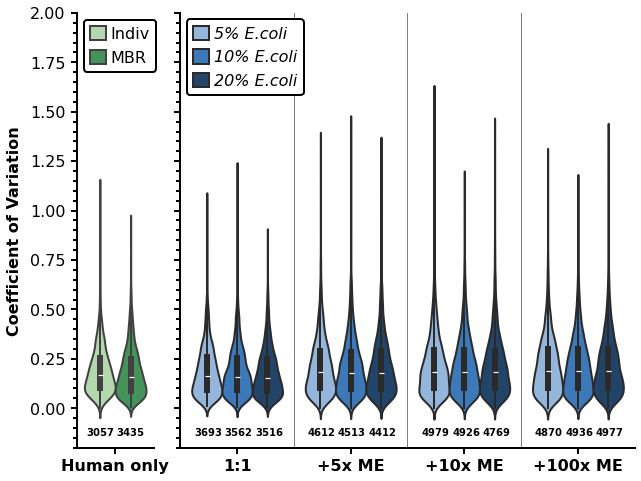

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True, gridspec_kw={'width_ratios': [1, 5.9]})
plt.subplots_adjust(wspace=0.1)
axs = fig.axes

sns.violinplot(data=cv_melt[cv_melt['Spike'] == 'Human only'], x='Spike', y='value', hue='Type', linewidth=lw, 
               width=0.8, palette=palette[0], ax=axs[0], density_norm='width', inner_kws={'box_width': 6})
sns.violinplot(data=cv_melt[cv_melt['Spike'] != 'Human only'], x='Type', y='value', hue='Spike', linewidth=lw, 
               width=0.8, palette=palette[1:4], ax=axs[1], density_norm='width', inner_kws={'box_width': 6})

for ax in axs:
    ax.set_ylim(-0.2, 2)
    ax.set_xlabel('')
    ax.set_ylabel('Coefficient of Variation', fontsize=fontsize, fontweight='bold', labelpad=8)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.tick_params(axis='y', which='minor', direction='out', pad=5, length=lw*2, width=lw)
    
    for axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(lw)

xlabels = ['1:1', '+5x ME', '+10x ME', '+100x ME']
axs[1].set_xticklabels(xlabels, fontsize=fontsize, fontweight='bold')
axs[0].set_xticklabels(['Human only'], fontsize=fontsize, fontweight='bold')

for i in range(3):
    axs[1].axvline(x=(i+0.5), color='grey', lw=lw/2)

for i, col in enumerate(cv_df.columns):
    prots = len(cv_df[col].dropna())
    if i <= 1:
        axs[0].text(x=-0.38+0.4*i, y=-0.14, s=prots, fontsize=fontsize-6, fontweight='bold')   
        
    if '+1_' in col:
        axs[1].text(x=-0.38+0.067*(i-2), y=-0.14, s=prots, fontsize=fontsize-6, fontweight='bold')
    if '+5_' in col:
        axs[1].text(x=0.55+0.067*(i-2), y=-0.14, s=prots, fontsize=fontsize-6, fontweight='bold')
    if '+10_' in col:
        axs[1].text(x=1.49+0.067*(i-2), y=-0.14, s=prots, fontsize=fontsize-6, fontweight='bold')
    if '+100_' in col:
        axs[1].text(x=2.42+0.067*(i-2), y=-0.14, s=prots, fontsize=fontsize-6, fontweight='bold')

legend1 = axs[0].legend(fontsize=fontsize, ncol=1, handletextpad=0.3, loc=(0.09,0.865), 
                        handlelength=1, handleheight=1, borderaxespad=0.4, framealpha=1, edgecolor='k')
legend2 = axs[1].legend(fontsize=fontsize, ncol=1, handletextpad=0.3, prop=dict(style='italic', size=fontsize), 
                        loc=2, handlelength=1, handleheight=1, borderaxespad=0.4, framealpha=1, edgecolor='k')
legend1.get_frame().set_linewidth(lw)
legend2.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/Protein_Quan_CVs_Violins.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_CVs_Violins.pdf', dpi=400, bbox_inches='tight')

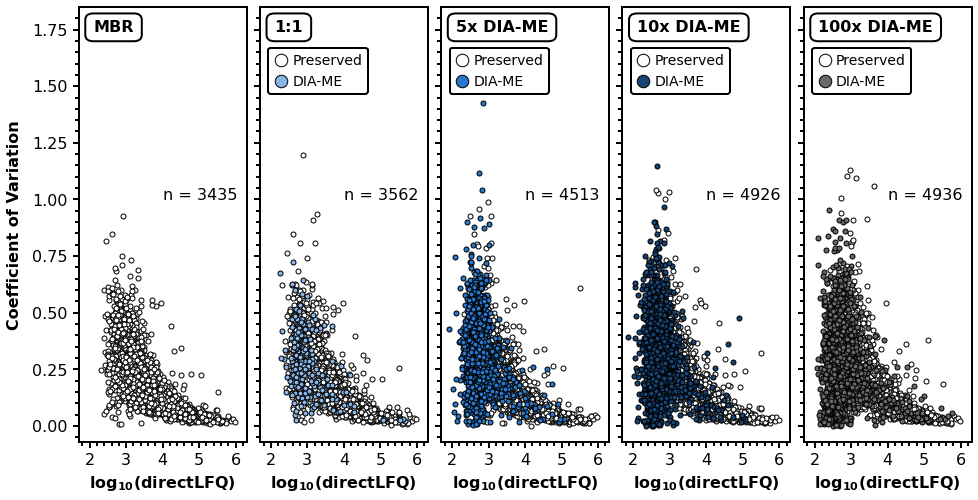

In [35]:
cv_df['Median'] = np.log10(merge.median(axis=1))
cv_df['new ids'] = np.where(cv_df['mbr'].isna(), '+', '')

cv_cols = ['mbr'] + [c for c in cv_df if '_10' in c]

old_cv = cv_df[cv_df['new ids'] != '+'][['Median'] + cv_cols]
new_cv = cv_df[cv_df['new ids'] == '+'][['Median'] + cv_cols]

fig, ax = plt.subplots(1,5, figsize=(16,8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)
axs = fig.axes

titles = ['MBR', '1:1', '5x DIA-ME', '10x DIA-ME', '100x DIA-ME']
for i, ax in enumerate(axs):
    
    sns.scatterplot(data=old_cv, x='Median', y=cv_cols[i], s=size, color='white', edgecolor='black', 
                    linewidth=1, ax=axs[i])
    sns.scatterplot(data=new_cv, x='Median', y=cv_cols[i], s=size, color=palette[i], edgecolor='black', 
                    linewidth=1, ax=axs[i])

    ax.text(x=2.1, y=1.74, s=titles[i], fontsize=16, weight='bold', bbox=props)
    
    ax.set_xlim([1.7, 6.3])
    ax.set_ylim([-0.07, 1.85])
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', direction='out', length=lw*2, width=lw)
    ax.set_xticks([2, 3, 4, 5, 6])
    
    ax.set_xlabel('log'+r'$\bf{_{10}}$'+'(directLFQ)', fontsize=fontsize, weight='bold', labelpad=6)
    ax.set_ylabel('Coefficient of Variation', fontsize=fontsize, weight='bold', labelpad=10)

    ax.text(4, 1, 'n = ' + str(len(cv_df[cv_cols[i]].dropna())), fontsize=fontsize)
    
    if i > 0:
        legend = ax.legend(labels=['Preserved', 'DIA-ME'], markerscale=2.5, fontsize=fontsize-2,
                        ncol=1, columnspacing=1, handlelength=1, handleheight=1, handletextpad=0.3, edgecolor='black', 
                        framealpha=1, loc=(0.05, 0.8))
        legend.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/Protein_Quan_CVs_Scatters.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_CVs_Scatters.pdf', dpi=400, bbox_inches='tight')

Text(-17, 93.5, '20% E.coli')

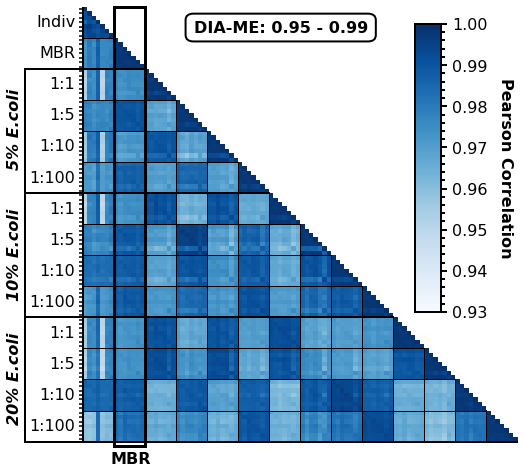

In [36]:
pearson = merge.corr(method='pearson')
mask_ut = np.triu(np.ones(pearson.shape),1).astype(bool)

labels = ['','','','Indiv','','','',
          '','','','MBR','','','',
          '','','','1:1','','','',
          '','','','1:5','','','',
          '','','','1:10','','','',
          '','','','1:100','','','',
          '','','','1:1','','','',
          '','','','1:5','','','',
          '','','','1:10','','','',
          '','','','1:100','','','',
          '','','','1:1','','','',
          '','','','1:5','','','',
          '','','','1:10','','','',
          '','','','1:100','','','']

fig, ax = plt.subplots(1, 1, figsize=(9, 8))

cbar_ax = plt.axes([0.69, 0.35, 0.04, 0.5])

hmap = sns.heatmap(pearson, xticklabels=False, yticklabels=labels, vmin=0.93, vmax=1, mask=mask_ut, cmap='Blues',
                   cbar_kws={'shrink': 0.75}, linewidth=0, square=True, ax=ax, cbar_ax=cbar_ax)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=fontsize, rotation=0)

for axis in ['top', 'bottom', 'left', 'right']:
    cbar_ax.spines[axis].set_visible(True)
    cbar_ax.spines[axis].set_linewidth(2)

cbar_ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=fontsize, fontweight='bold', labelpad=25)
cbar_ax.minorticks_on()
cbar_ax.tick_params(axis='y', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
cbar_ax.tick_params(axis='y', which='minor', direction='out', pad=5, length=lw*2, width=lw)
ax.tick_params(axis='y', which='major', direction='out', pad=3.5, length=lw*2, width=1.5)

xy = (7, 0)
width = 7
height = 99
rect = mpl.patches.Rectangle(xy, width, height, linewidth=lw*1.5, edgecolor='black', facecolor='none', clip_on=False)
ax.add_patch(rect)
ax.text(x=6.3, y=103, s='MBR', fontsize=fontsize, weight='bold')

ax.text(25, 3, 'DIA-ME: 0.95 - 0.99', fontsize=fontsize, weight='bold', va='top', bbox=props)

for i in range(14):
    ax.axhline(y=98-7*i, xmax=1-0.0714*i, color='k', linewidth=lw/2)
    ax.axvline(x=7*i, ymax=1-0.0714*i, color='k', linewidth=lw/2)
for i in range(4):
    ax.axhline(98-28*i, xmin=-0.13, xmax=0.999-0.2847*i, color='k', linewidth=lw, clip_on=False)
for i in range(2):
    ax.axvline(x=0-13*i, ymax=0.998-0.141*i, color='k', linewidth=lw, clip_on=False)

ax.text(-17,36,'5% E.coli', rotation=90, fontsize=fontsize, fontweight='bold', style='italic')
ax.text(-17,65.5,'10% E.coli', rotation=90, fontsize=fontsize, fontweight='bold', style='italic')
ax.text(-17,93.5,'20% E.coli', rotation=90, fontsize=fontsize, fontweight='bold', style='italic')

# plt.savefig('02_Figures/Protein_Quan_Pearson_Heatmap.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_Pearson_Heatmap.pdf', dpi=400, bbox_inches='tight')

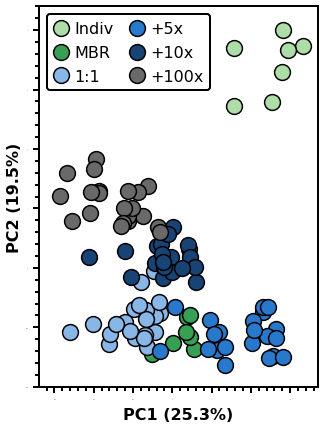

In [38]:
pca = PCA(n_components=2).fit_transform(merge.dropna().T)
pca = pd.DataFrame(pca, columns=['x','y'])
pca['Experiment'] = merge.columns
pca[['Type', 'Spike']] = pca['Experiment'].str.split('_', expand=True).replace({'indiv': 'Indiv', 'mbr': 'MBR'})

fig, ax = plt.subplots(1,1, figsize=(5, 7))

factor = 100000
for i, cond in enumerate(pca['Type'].unique()):
    frame = pca[pca['Type'] == cond][['x', 'y']]/factor
    if i <= 1:
        color = sns.color_palette(palette[0],2)[i]
    elif i > 1:
        color = palette[i-1]
        
    sns.scatterplot(data=frame, x='x', y='y', s=size*10, edgecolor='black', linewidth=1.5, color=color)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
    
xvar, yvar = PCA(n_components=2).fit(merge.dropna().T).explained_variance_ratio_
ax.set_xlabel('PC1 (' + str(round(xvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize, labelpad=8)
ax.set_ylabel('PC2 (' + str(round(yvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=0, length=lw*3, width=lw, pad=5)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw, pad=5)

ax.set_xlim([-3.4, 3.7])
ax.set_ylim([-2, 4.4])

legend = plt.legend(labels=['Indiv', 'MBR', '1:1', '+5x', '+10x', '+100x'], markerscale=1, fontsize=fontsize,
                    ncol=2, columnspacing=1, handlelength=1, handleheight=1, handletextpad=0.3, edgecolor='black', 
                    framealpha=1)
legend.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/Protein_Quan_PCA.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_PCA.pdf', dpi=400, bbox_inches='tight')